In [1]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./models/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
./models/lag-llama/lag-llama.ckpt


In [2]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/anton/miniconda3/envs/citywise/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
ckpt = torch.load("./models/lag-llama/lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [4]:
estimator = LagLlamaEstimator(
    ckpt_path="./models/lag-llama/lag-llama.ckpt",
    prediction_length=24*7,
    context_length=24*7*2,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [5]:
# Number of parameters
sum([p.numel() for p in lightning_module.parameters()])

2449299

In [6]:
train = pd.read_csv("./60min_clustered_sensors.csv", index_col=0, parse_dates=True)
subset = train.iloc[:10000]
subset["occupied"] = subset["occupied"].astype(np.float32)
subset.head()

/tmp/ipykernel_7422/3996688299.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train = pd.read_csv("./60min_clustered_sensors.csv", index_col=0, parse_dates=True)


,time,occupied
0,2023-02-15 00:00:00,1.345455
1,2023-02-15 01:00:00,1.333333
2,2023-02-15 02:00:00,1.833333
3,2023-02-15 03:00:00,1.766667
4,2023-02-15 04:00:00,0.566667


In [7]:
from gluonts.dataset.pandas import PandasDataset
ds = PandasDataset(subset, target="occupied", timestamp="time", freq="60min")

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds,
    predictor=predictor,
)

In [9]:
# Takes a minute depending on hardware
forecasts =list(forecast_it)
tss = list(ts_it)

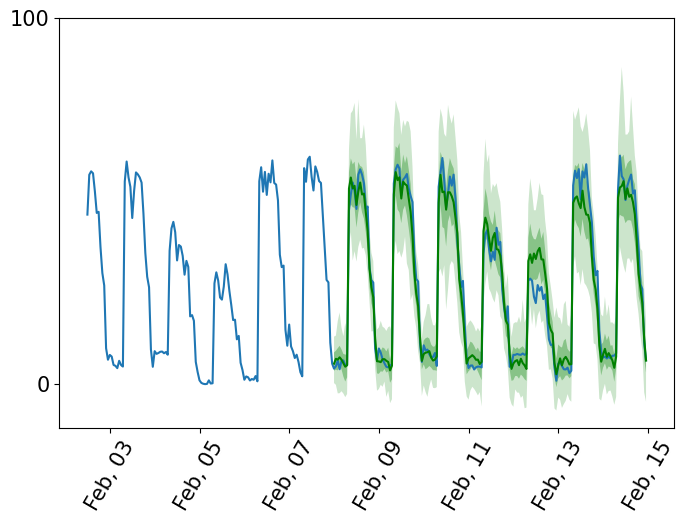

In [10]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-300:].to_timestamp())
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)
    ax.set_yticks([0, 100])

plt.gcf().tight_layout()
plt.show()